## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [10]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        some_const = 600
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, some_const),
            nn.LeakyReLU(),
            nn.Linear(some_const, some_const),
            nn.LeakyReLU(),
            nn.Linear(some_const, num_classes)
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [11]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 600]         471,000
         LeakyReLU-3                  [-1, 600]               0
            Linear-4                  [-1, 600]         360,600
         LeakyReLU-5                  [-1, 600]               0
            Linear-6                   [-1, 10]           6,010
Total params: 837,610
Trainable params: 837,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.20
Estimated Total Size (MB): 3.22
----------------------------------------------------------------


Your experiments come here:

In [227]:
model = TinyNeuralNetwork().to(device)
learning_rate = 1e-2
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
epochs = 30
log_interval=100
training_accuracy = 0
loss_history = []

for epoch in range(epochs):
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    opt.zero_grad()
    model_out = model(data)
    model_out = model_out.to(device)
    training_accuracy += (torch.eq(target, torch.argmax(model_out, -1)).float().mean())
    loss = loss_func(model_out, target)
    loss.backward()
    opt.step()
    loss_history.append(loss)
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]tLoss: {:.6f}'.format(
                   epoch, batch_idx * len(data), len(train_loader.dataset),
                          100. * batch_idx / len(train_loader), loss.data))
  training_accuracy = training_accuracy / batch_idx
  print('Training accuracy: ' + str(float(training_accuracy)))
  training_accuracy = 0

Train Epoch: 0 [0/60000 (0%)]tLoss: 2.304928
Train Epoch: 0 [12800/60000 (21%)]tLoss: 0.829628
Train Epoch: 0 [25600/60000 (43%)]tLoss: 0.760935
Train Epoch: 0 [38400/60000 (64%)]tLoss: 0.613395
Train Epoch: 0 [51200/60000 (85%)]tLoss: 0.459715
Training accuracy: 0.7105202078819275
Train Epoch: 1 [0/60000 (0%)]tLoss: 0.488095
Train Epoch: 1 [12800/60000 (21%)]tLoss: 0.448559
Train Epoch: 1 [25600/60000 (43%)]tLoss: 0.532792
Train Epoch: 1 [38400/60000 (64%)]tLoss: 0.407067
Train Epoch: 1 [51200/60000 (85%)]tLoss: 0.442647
Training accuracy: 0.8303285837173462
Train Epoch: 2 [0/60000 (0%)]tLoss: 0.364808
Train Epoch: 2 [12800/60000 (21%)]tLoss: 0.409744
Train Epoch: 2 [25600/60000 (43%)]tLoss: 0.552709
Train Epoch: 2 [38400/60000 (64%)]tLoss: 0.406365
Train Epoch: 2 [51200/60000 (85%)]tLoss: 0.374583
Training accuracy: 0.8505163788795471
Train Epoch: 3 [0/60000 (0%)]tLoss: 0.309542
Train Epoch: 3 [12800/60000 (21%)]tLoss: 0.371626
Train Epoch: 3 [25600/60000 (43%)]tLoss: 0.465768
Train 

Average loss: 0.0000, Accuracy: 0.8077


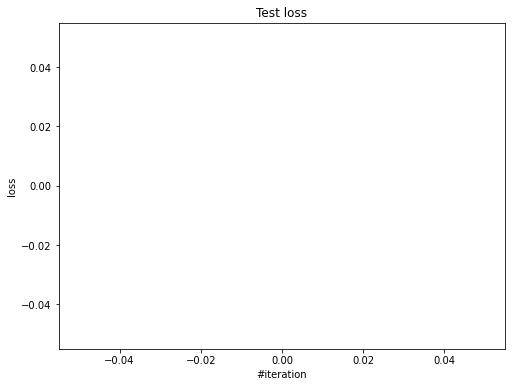

Current loss: 0.312632


In [233]:
test_loss = 0
correct = 0
test_accuracy = 0
loss_history = []

for data, target in test_loader:
   data = data.to(device)
   target = target.to(device)
   model_out = model(data)
   loss = loss_func(model_out, target).data
   test_loss += loss
   #loss_history.append(loss)
   test_accuracy += torch.eq(target, torch.argmax(model_out.data, -1)).float().mean()


test_loss = torch.tensor(loss_history).sum() / len(test_loader.dataset)
test_accuracy /= len(test_loader)
print('Average loss: {:.4f}, Accuracy: {:.4f}'.format(
       test_loss, test_accuracy, len(test_loader.dataset)))

plt.figure(figsize=(8, 6))
    
plt.title("Test loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, 'b')
plt.show()

print('Current loss: %f' % loss)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [7]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        some_big_const = 1800
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, some_big_const), 
            nn.ReLU(), 
            nn.Linear(some_big_const, input_shape), 
            nn.ReLU(), 
            nn.Linear(input_shape, input_shape), 
            nn.ReLU(), 
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        return self.model(inp)


In [8]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1800]       1,413,000
              ReLU-3                 [-1, 1800]               0
            Linear-4                  [-1, 784]       1,411,984
              ReLU-5                  [-1, 784]               0
            Linear-6                  [-1, 784]         615,440
              ReLU-7                  [-1, 784]               0
            Linear-8                   [-1, 10]           7,850
Total params: 3,448,274
Trainable params: 3,448,274
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 13.15
Estimated Total Size (MB): 13.21
----------------------------------------------------------------


In [19]:
model =  OverfittingNeuralNetwork().to(device)
learning_rate = 1e-2
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_func = nn.CrossEntropyLoss()
print(fmnist_dataset_train.data.shape)
train_loader_trunc = torch.utils.data.DataLoader(fmnist_dataset_train[:15000], 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)


torch.Size([60000, 28, 28])


AttributeError: ignored

In [20]:
model =  OverfittingNeuralNetwork().to(device)
learning_rate = 1e-2
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_func = nn.CrossEntropyLoss()
#loss_func = nn.NLLLoss()


# Your experiments, training and validation loops here
epochs = 40
log_interval=100
training_batch_size = 128
training_accuracy = 0

loss_history = []
loss_history_test = []


for epoch in range(epochs):
  for batch_idx, (data, target) in enumerate(train_loader_trunc):
    data = data.to(device)
    target = target.to(device)
    opt.zero_grad()
    model_out = model(data).to(device)
    training_accuracy += (torch.eq(target, torch.argmax(model_out, -1)).float().mean())
    loss = loss_func(model_out, target)
    loss.backward()
    opt.step()
    loss_history.append(loss)
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]tLoss: {:.6f}'.format(
                   epoch, batch_idx * len(data), len(train_loader_trunc.dataset),
                          100. * batch_idx / len(train_loader_trunc), loss.data))
  training_accuracy = training_accuracy / batch_idx
  print('Training accuracy: ' + str(float(training_accuracy)))
  training_accuracy = 0

  test_loss = torch.tensor(np.ndarray((256, 10))).to(device)
  for test_data, test_target in test_loader:
    test_data = test_data.to(device)
    test_target = test_target.to(device)
    model_out = model(test_data).to(device)
    test_loss += loss_func(model_out, test_target)
    
    
  print(test_loss.mean() / len(test_loader))
  loss_history_test.append(test_loss.mean() / len(test_loader))
  

plt.figure(figsize=(8, 6))
    
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history_test, 'b')
plt.show()

print('Current loss: %f' % loss)

ValueError: ignored

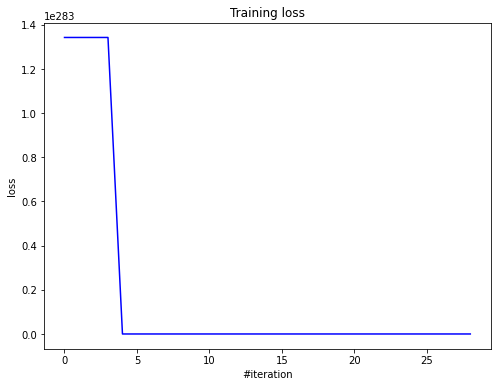

Current loss: 0.120789


In [18]:
plt.figure(figsize=(8, 6))
    
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history_test, 'b')
plt.show()

print('Current loss: %f' % loss)

0.49290674924850464
0.5130499601364136
0.43590953946113586
0.45735907554626465
0.3868239223957062
0.46315839886665344
0.216996431350708
0.41609442234039307
0.23908595740795135
0.5195851922035217
0.48895490169525146
0.7692153453826904
0.5249449014663696
0.8136791586875916
0.5510523915290833
0.5701797604560852
0.4205814599990845
0.2849576771259308
0.5405169129371643
0.5470057129859924
0.5212822556495667
0.7743275761604309
0.36317089200019836
0.4212670624256134
0.3663294315338135
0.5551005005836487
0.35752764344215393
0.48447591066360474
0.419384628534317
0.2475580871105194
0.39322400093078613
0.34857290983200073
0.39301204681396484
0.3762456774711609
0.6233770251274109
0.4101601243019104
0.5900112390518188
0.3887355327606201
0.4083695113658905
0.001814792980439961
10000
40
Average loss: 0.0018096002, or 0.179422989487648 Accuracy: 0.9014


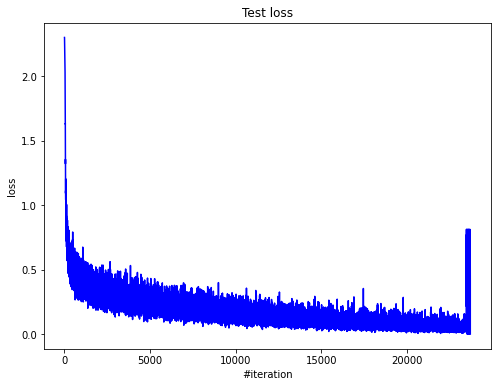

Current loss: 0.001815


In [226]:
test_loss = 0
correct = 0
test_accuracy = 0
loss_history = []

for data, target in test_loader:
   data = data.to(device)
   target = target.to(device)
   model_out = model(data)
   loss = loss_func(model_out, target)
   test_loss += loss
   loss_history.append(loss)
   test_accuracy += torch.eq(target, torch.argmax(model_out.data, -1)).float().mean()
   print(float(loss))


print(len(test_loader.dataset))
print(len(test_loader))
test_loss /= len(test_loader.dataset)
test_loss_2 = torch.tensor(loss_history).mean()
test_accuracy /= len(test_loader)
print('Average loss: {:.10f}, or {} Accuracy: {:.4f}'.format(
       test_loss, test_loss_2, test_accuracy, len(test_loader.dataset)))

plt.figure(figsize=(8, 6))
    
plt.title("Test loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, 'b')
plt.show()

print('Current loss: %f' % loss)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

### Conclusions:
_Write down small report with your conclusions and your ideas._